## Diffusion equation
Example is taken from 
[Schwab/Hoang paper](ftp://ftp.math.ethz.ch/hg/pub/sam-reports/reports/reports2003/2003-14.pdf)

$$K(x) = K_0(x) K_1(\frac{x}{\varepsilon}),$$

where $K_0 = 1 + x$, $K_1 = 2/3 (1 + \cos^2(2 \pi \frac{x}{\varepsilon}))$

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy as sp
import scipy.interpolate
import math
import numpy as np
import tt

def Kfun(x, eps):
    #return np.ones(x.shape)
    return (1 + np.sqrt(x)) * 2/3 * (1 + np.cos(2 * math.pi * (x/eps)) ** 2)

def rhs_fun(x):
    return np.ones(x.shape)
    #return (1 + np.sqrt(np.abs(x-0.5)))
    #n = x.shape[0]
    #res = np.zeros(n)
    #res[n/2] = n
    #return res

def derivative(arr, fun, h):
    N = arr.shape[0]
    res = np.zeros(N)
    res[1:-1] = (arr[2:] - arr[:-2])/(2*h)
    res[0] = (arr[1] - 0.)/(2*h)
    res[-1] = (0. - arr[-2])/(2*h)
    mesh = np.linspace(0, 1, N + 2)[1:-1]
    return res #* fun(mesh)

def gen_full_matrix_new(d, eps, Kfun, a=0.0, b=1.0): 
    N = 2 ** d - 1
    t = np.arange(N)
    e = np.ones(N)
    h = (b - a)/(N + 1)
    cf = (t + 0.5 * e) * h
    am = Kfun(cf, eps)
    cf_plus = (t + 1.5 * e) * h
    ap = Kfun(cf_plus, eps)
    dg = am + ap
    dg = np.concatenate(([h**2], dg))
    am = np.concatenate((am, [0]))
    ap = np.concatenate(([0, 0], ap[:-1]))
    mat = scipy.sparse.spdiags([-am, -ap, dg], [-1, 1, 0], N+1, N+1, format='csr')
    mat = mat/h**2
    return mat

#print gen_full_matrix_new(2, 1e-2, Kfun, a=0.0, b=1.0).todense()
#print Kfun(0.5/2**3, 1e-2)*2**6

### Test

0.243774511755


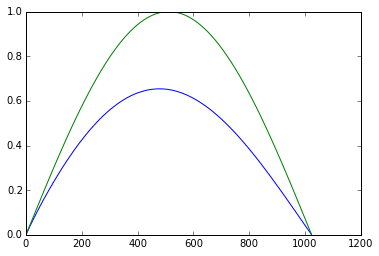

In [86]:
eps = 1e-2

d = 10
N = 2 ** d
h = 1.0 / (N)
x = np.linspace(0, 1, N+1)[:-1]
rhs = np.pi**2 * np.sin(np.pi * x)
mat = gen_full_matrix_new(d, eps, Kfun, a=0.0, b=1.0)
sol_exact = np.sin(np.pi * x)
sol = sp.sparse.linalg.spsolve(mat, rhs)
print np.linalg.norm(sol - sol_exact)*np.sqrt(h)
plt.plot(sol)
plt.plot(sol_exact)

In [87]:
x = np.linspace(0, 1, N + 1)
res = np.zeros(N+1)
sol2 = sol
for i in xrange(1, N):
    k = (sol2[i] - sol2[i-1])/h
    res[i] = h * k**2 - 2*k * (np.sin(np.pi * x[i]) - np.sin(np.pi * x[i-1])) + np.pi**2*h/2 + np.pi/(4) * \
                              (np.sin(2 * np.pi * x[i]) - np.sin(2 * np.pi * x[i-1]))
#print res
print np.sqrt(res.sum())

0.86382906155


In [88]:
eps = 1e-3
dmin = 5
dmax = 21
dd = dmax - dmin
dims = []
sols = []
sols_interp = []
ders = []
ders_interp = []
h_all = []
meshes = []
matrs = []

for i in range(dd):
    d = dmin + i
    dims.append(d)
    N = 2 ** d
    h = 1.0/(N)
    h_all.append(h)
    mat = gen_full_matrix_new(d, eps, Kfun, a=0.0, b=1.0)
    matrs.append(mat)
    meshes.append(np.linspace(0, 1, N+1))
    rhs = rhs_fun(meshes[i][:-1])
    res = np.zeros(N + 1)
    res[:-1] = sp.sparse.linalg.spsolve(mat, rhs)
    sols.append(res)

In [89]:
dall = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
eps_all = [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
tau_all = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

### Massive tests

In [90]:
dall = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
eps_all = 10 ** (-np.linspace(1, 5, 53)) #[1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
tau_all = 10 ** (-np.linspace(1, 11, 101))
# tau_all = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

res = {}
for eps in eps_all:
    print eps
    dims = []
    sols = []
    sols_interp = []
    h_all = []
    meshes = []
    matrs = []

    for d in dall:
        i = d - dall[0]
        dims.append(d)
        N = 2 ** d
        h = 1.0/(N)
        h_all.append(h)
        mat = gen_full_matrix_new(d, eps, Kfun, a=0.0, b=1.0)
        meshes.append(np.linspace(0, 1, N+1))
        rhs = rhs_fun(meshes[i][:-1])
        result = np.zeros(N + 1)
        result[:-1] = sp.sparse.linalg.spsolve(mat, rhs)
        sols.append(result)

    for d in dall[:-2]:
        i = d - dall[0]
        h = h_all[i+2]

        solh = sols[i+2]
        sol2h = np.zeros(sols[i+2].shape)
        sol2h[::2] = sols[i+1]
        sol2h[1::2] = (sols[i+1][:-1] + sols[i+1][1:])/2
        sol_extrap = solh + (solh - sol2h) / (2.0**2 + 1)

        kh = (sols[i+2][1:] - sols[i+2][:-1]) / h
        kh_extrap = (sol_extrap[1:] - sol_extrap[:-1])/h
        for tau in tau_all:
            #kh_qtt = tt.tensor(kh.reshape(2*np.ones(d+2), order='F'), tau)
            #kh_qtt_full = kh_qtt.full().flatten('F')
            solh_qtt_full = np.zeros(len(solh))
            solh_qtt = tt.tensor(solh[:-1].reshape(2*np.ones(d+2), order='F'), tau)
            solh_qtt_full[:-1] = solh_qtt.full().flatten('F')
            kh_qtt_full = (solh_qtt_full[1:] - solh_qtt_full[:-1]) / h
            res[(d+2, tau, eps, 'memory')] = len(solh_qtt.core)
            res[(d+2, tau, eps, 'h1_qtt')] = np.linalg.norm(kh_qtt_full - kh_extrap) * np.sqrt(h)
            res[(d+2, tau, eps, 'h1')] = np.linalg.norm(kh - kh_extrap) * np.sqrt(h) 
            res[(d+2, tau, eps, 'l2')] = np.linalg.norm(solh - sol_extrap) * np.sqrt(h) 
                                   
            
np.savez('computations_diffusion', res=res, dall=dall[2:], eps_all=eps_all, tau_all=tau_all)

0.1
0.0837677640068
0.070170382867
0.0587801607227
0.0492388263171
0.041246263829
0.0345510729459
0.0289426612472
0.0242446201708
0.020309176209
0.0170125427985
0.014251026703
0.0119377664171
0.01
0.00837677640068
0.0070170382867
0.00587801607227
0.00492388263171
0.0041246263829
0.00345510729459
0.00289426612472
0.00242446201708
0.0020309176209
0.00170125427985
0.0014251026703
0.00119377664171
0.001
0.000837677640068
0.00070170382867
0.000587801607227
0.000492388263171
0.00041246263829
0.000345510729459
0.000289426612472
0.000242446201708
0.00020309176209
0.000170125427985
0.00014251026703
0.000119377664171
0.0001
8.37677640068e-05
7.0170382867e-05
5.87801607227e-05
4.92388263171e-05
4.1246263829e-05
3.45510729459e-05
2.89426612472e-05
2.42446201708e-05
2.0309176209e-05
1.70125427985e-05
1.4251026703e-05
1.19377664171e-05
1e-05


In [49]:
np.linspace(0,3,7)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ])

In [20]:
order_sol = []
order_der = []
h1_norm = []
l2_norm = []
tau = 1e-10
for i in range(dd-2):
    d = i + dmin
    h = h_all[i+2]
    kh = (sols[i+2][1:] - sols[i+2][:-1]) / h
    k2h = (sols[i+1][1:] - sols[i+1][:-1]) / (2*h)
    k2h = np.repeat(k2h, 2)
    h1_norm.append(np.sqrt(((kh - k2h)**2 ).sum())/np.linalg.norm(kh))
    
    solh = sols[i+2]
    sol2h = np.zeros(sols[i+2].shape)
    sol2h[::2] = sols[i+1]
    sol2h[1::2] = (sols[i+1][:-1] + sols[i+1][1:])/2
    l2_norm.append(np.sqrt(((solh - sol2h)**2 * h).sum()))
    
    #order = np.linalg.norm(sol2h - sol4h) / np.linalg.norm(solh - sol2h)
    #order = np.log2(order)
    sol_extrap = solh + (solh - sol2h) / (2**2 + 1)
    k_extrap = (sol_extrap[1:] - sol_extrap[:-1])/h
    print np.linalg.norm((k_extrap - kh))*np.sqrt(h)
    sol_qtt = tt.tensor(solh[:-1].reshape(2*np.ones(i+2+dmin), order='F'), tau)
    #print sol_qtt.erank
    sol_qtt = sol_qtt.full().flatten('F')
    #print np.linalg.norm(sol_extrap[:-1] - sol_qtt)/np.linalg.norm(sol_extrap[:-1])
    
h1_norm = np.array(h1_norm)
l2_norm = np.array(l2_norm)
#print h1_norm
#print np.log2(h1_norm[:-1]/h1_norm[1:])
#print np.log2(l2_norm[:-1]/l2_norm[1:])

0.0472076898419
0.0217206046585
0.0968170711514
0.0673785638083
0.0368180914148
0.0957612863147
0.0642874294344
0.0920330681617
0.0810764789931
0.0469422897073
0.0243952141653
0.0123179259477
0.00617416234145
0.00308898615632


## 1D Helmholtz 

In [301]:
#Generate the tridiagonal sparse matrix
import numpy as np
import scipy.linalg
from scipy import interpolate

def gen_helmholtz_matrix(d, K, a=0.0, b=1.0):
    N = 2 ** d
    t = np.linspace(a, b, N+1) #Left point ommited
    h = 1. / N
    ap = -np.ones(N) / h ** 2 - K**2 / 6
    am = -np.ones(N) / h ** 2 - K**2 / 6
    dg = 2 * np.ones(N, dtype=np.complex128)/h**2 - (K**2)*2./3
    dg[0] = 2./h**2 - (K**2) * 1./3 
    dg[N-1] = 1.0 / h**2 - (K**2)/3 - 1j*K / h  #Radiation b.c.
    mat = scipy.sparse.spdiags([am, ap, dg], [1, -1, 0], N, N).tocsc()
    return mat

def h1_norm_func(kh, h, K, N):
    h1_real = (h * kh.real**2 - 2*kh.real*(np.cos(K*h*np.arange(1, N)) - np.cos(K*h*np.arange(0, N-1))) + K**2*h/2 -
        K/4 * (np.sin(2*K*h*np.arange(1, N)) - np.sin(2*K*h*np.arange(0, N-1)))).sum()
    h1_imag = (h * kh.imag**2 - 2*kh.imag*(np.sin(K*h*np.arange(1, N)) - np.sin(K*h*np.arange(0, N-1))) + K**2*h/2 +
        K/4 * (np.sin(2*K*h*np.arange(1, N)) - np.sin(2*K*h*np.arange(0, N-1)))).sum()
    return np.sqrt((h1_imag + h1_real)/2)

def rhs_fun(x):
    res = np.zeros(x.shape, dtype=np.complex128)
    res[0] = 1.
    return res #np.ones(x.shape, dtype=np.complex128)

def solution_fun(x, k):
    return (1j/k) * (1.-np.exp(1j*k)/2) * np.exp(1j*k*x) - 1j*(np.exp(1j*k)/(2*k)) * np.exp(-1j*k*x)
%load_ext line_profiler
from numba import jit
def h1_error_fun(kh, h, k, num_int=30):
    err = 0.
    grid_int = np.linspace(0, h, num_int)
    step_int = (grid_int[1] - grid_int[0])
    c1 = (1j/k) * (1.-np.exp(1j*k)/2) * np.exp(1j*k*grid_int)
    c2 = 1j*(np.exp(1j*k)/(2*k)) * np.exp(-1j*k*grid_int)
    for i in xrange(len(kh)):
        #grid_int += h
        delta = kh[i] - c1 * np.exp(1j*k*h*i) + c2 * np.exp(-1j*k*h*i)
        err += np.sum(np.abs(delta)**2) * step_int
    return np.sqrt(err)

def trig_squared_integral(c1, c2, c3, x, k): #integrates (c1 cos kx + c2 sin kx + c3)^2
    return c1**2 * (x/2 + np.sin(2*k*x)/(4*k)) + c2**2 * (x/2 - np.sin(2*k*x)/(4*k)) + c3**2*x - \
           c1*c2*np.cos(2*k*x)/(2*k) + 2*c1*c3*np.sin(k*x)/k - 2*c2*c3*np.cos(k*x)/k 
    
def h1_norm_func2(kh, h, k, N):
    c1 = 1.0j/k * (1 - np.exp(1j*k)/2)
    c2 = -1.0j*np.exp(1j*k)/(2*k)
    res = trig_squared_integral(c1.real+c2.real, -c1.imag+c2.imag, -kh.real, h*np.arange(1, N), k) - \
          trig_squared_integral(c1.real+c2.real, -c1.imag+c2.imag, -kh.real, h*np.arange(0, N-1), k) + \
          trig_squared_integral(c1.imag+c2.imag, c1.real-c2.real, -kh.imag, h*np.arange(1, N), k) - \
          trig_squared_integral(c1.imag+c2.imag, c1.real-c2.real, -kh.imag, h*np.arange(0, N-1), k)
    return np.sqrt(res.sum())

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Helmholtz test

6.67504001974e-05
0.706395305502


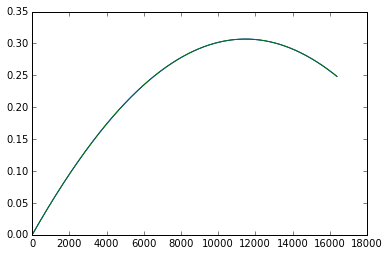

In [304]:
d = 14
N = 2 ** d
h = 1. / N
f = np.ones(N, dtype=np.complex128)
#f[0] = 1.0 / h**2
K = 1.
a = gen_helmholtz_matrix(d, K)
grid = np.linspace(0, 1, N+1)
sol_exact = np.exp(1j * K * grid[1:])
sol_num = sp.sparse.linalg.spsolve(a, f)

kh = (sol_num[1:] - sol_num[:-1]) / h
print h1_norm_func2(kh, h, K, N)
#%lprun -f h1_error_fun h1_error_fun(kh, h, K, num_int=100) #h1_norm_func(kh, h, K, N)

print np.linalg.norm(sol_exact - sol_num) * np.sqrt(h)
plt.plot(np.real(sol_num))
plt.plot(np.real(sol_num))

0.0

0.823044734355
1.20365413569


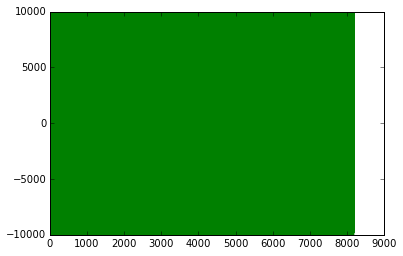

In [252]:
d = 13
N = 2 ** d
h = 1. / N
f = np.zeros(N, dtype=np.complex128)
f[0] = 1.0 / h**2
K = 10000.
a = gen_helmholtz_matrix(d, K)
grid = np.linspace(0, 1, N+1)
sol_exact = np.exp(1j * K * grid[1:])
sol_num = sp.sparse.linalg.spsolve(a, f)

kh = (sol_num[1:] - sol_num[:-1]) / h
#interp = interpolate.interp1d(grid[:-1], kh, kind='zero')


print  h1_norm_func(kh, h, K, N) / (K)

print np.linalg.norm(sol_exact - sol_num) * np.sqrt(h)
#plt.plot(np.real(sol_num))
#plt.plot(np.real(sol_num))
plt.plot(kh.real)
plt.plot(-K*np.sin(K*grid))

In [16]:
for i in xrange(2**20):
    np.arcsin(np.arange(10))

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in arcsin
  from IPython.kernel.zmq import kernelapp as app


In [163]:
kh.real

array([ -286.02250304,  -476.57237695,  -666.94888536, ...,  1110.071985  ,
        1299.37104026,  1488.19741575])

In [125]:
2./h / K

209.7152

## Massive experiments

In [137]:
x

array([  0.00000000e+00,   9.76562500e-04,   1.95312500e-03, ...,
         9.98046875e-01,   9.99023438e-01,   1.00000000e+00])

In [158]:
from sympy import integrate as spintegrate
from sympy.abc import a, x, y
import sympy
res = spintegrate((1 - x**2)**2, (x,0,a))
print res

TypeError: 'module' object is not callable

In [155]:
res.func(1.)

1

In [308]:
dall = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
K_all = [1., 5., 10., 50., 100., 500.,  1000., 5000., 10000.] #[1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
tau_all = 10 ** (-np.linspace(1, 11, 101))
# tau_all = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

res = {}
for K in K_all:
    print 'k =', K
    dims = []
    sols = []
    sols_interp = []
    h_all = []
    meshes = []
    matrs = []
    err_l2_temp = []

    for d in dall:
        i = d - dall[0]
        dims.append(d)
        N = 2 ** d
        h = 1.0/(N)
        h_all.append(h)
        mat = gen_helmholtz_matrix(d, K, a=0.0, b=1.0)
        meshes.append(np.linspace(0, 1, N+1))
        rhs = np.ones(N, dtype=np.complex128)#rhs_fun(meshes[i][1:]) / h**2
        result = np.zeros(N+1, dtype=np.complex128)
        result[1:] = sp.sparse.linalg.spsolve(mat, rhs)
        sols.append(result)
        #kh = (result[2:] - result[1:-1])/h
        #print h1_norm_func(kh, h, K, N)

    for d in dall[:-2]:
        i = d - dall[0]
        h = h_all[i+2]
        
        solh = sols[i+2]
        sol2h = np.zeros(sols[i+2].shape, dtype=np.complex128)
        sol2h[::2] = sols[i+1]
        sol2h[1::2] = (sols[i+1][:-1] + sols[i+1][1:])/2
        err_l2_temp.append(np.linalg.norm(solh - sol2h) * np.sqrt(h))
        try:
            order = 2. #np.log2(err_l2_temp[i-1] / err_l2_temp[i])
        except:
            order = 2.
        #print 'order = ', order
        sol_extrap = solh + (solh - sol2h) / (2.0**order - 1)
        kh = (sols[i+2][1:] - sols[i+2][:-1]) / h
        kh_extrap = (sol_extrap[1:] - sol_extrap[:-1])/h
        for tau in tau_all:
            #kh_qtt = tt.tensor(kh.reshape(2*np.ones(d+2), order='F'), tau)
            #kh_qtt_full = kh_qtt.full().flatten('F')
            solh_qtt_full = np.zeros(len(solh), dtype=np.complex128)
            solh_qtt = tt.tensor(solh[1:].reshape(2*np.ones(d+2), order='F'), tau)
            solh_qtt_full[1:] = solh_qtt.full().flatten('F')
            kh_qtt_full = (solh_qtt_full[1:] - solh_qtt_full[:-1]) / h
            res[(d+2, tau, K, 'memory')] = len(solh_qtt.core)
            res[(d+2, tau, K, 'h1_qtt')] = h1_norm_func2(kh_qtt_full, h, K, 2**(d+2)+1)# / K
            res[(d+2, tau, K, 'h1')] = h1_norm_func2(kh, h, K, 2**(d+2)+1)# / K
            res[(d+2, tau, K, 'l2')] = np.linalg.norm(solh - sol_extrap) * np.sqrt(h) 
            res[(d+2, tau, K, 'erank')] = solh_qtt.erank
            #print res[(d+2, tau, K, 'h1')], res[(d+2, tau, K, 'h1_qtt')]
            #print solh_qtt.erank
            #print res[(d+2, tau, K, 'h1')], res[(d+2, tau, K, 'h1_qtt')]
                                   
            
np.savez('computations_helmholtz', res=res, dall=dall[2:], K_all=K_all, tau_all=tau_all)

k = 1.0
k = 5.0
k = 10.0
k = 50.0
k = 100.0
k = 500.0
k = 1000.0
k = 5000.0
k = 10000.0


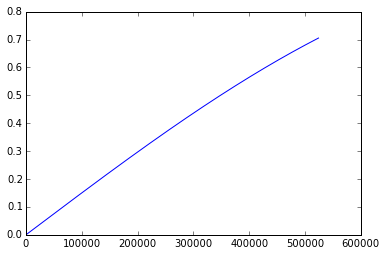

In [223]:
plt.plot(solh.imag)

In [81]:
solh

array([  0.00000000e+00+0.j,   3.05175781e-05+0.j,   6.10342249e-05+0.j,
       ...,   5.00015256e-01+0.j,   5.00015258e-01+0.j,
         5.00015259e-01+0.j])

In [83]:
solh - sol2h

array([  0.00000000e+00+0.j,  -1.06155150e-14+0.j,  -9.31343806e-10+0.j,
       ...,  -1.52580913e-05+0.j,  -1.52580913e-05+0.j,
        -1.52590226e-05+0.j])